In [ ]:
!pip -q install -U "transformers==4.44.2" "datasets==2.21.0" "accelerate==0.33.0"
import os; os.kill(os.getpid(), 9)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 79.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ope

Train=8000 | Val=2000 | Val sat rate=0.266


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.533900,0.529421,0.755500,0.633155,0.678754,0.621318
2,0.486900,0.524057,0.757500,0.552870,0.729711,0.564358
3,0.472700,0.531270,0.765000,0.629323,0.702332,0.616963



Validation report — bert_base:
              precision    recall  f1-score   support

       unsat     0.7906    0.9074    0.8450      1469
         sat     0.5669    0.3352    0.4213       531

    accuracy                         0.7555      2000
   macro avg     0.6788    0.6213    0.6332      2000
weighted avg     0.7312    0.7555    0.7325      2000



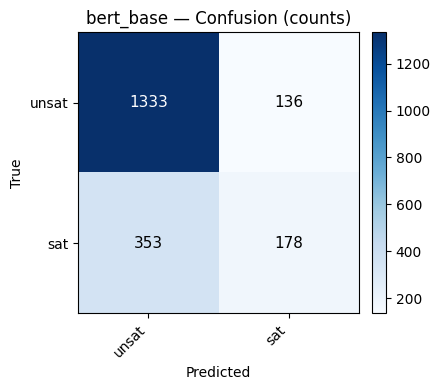

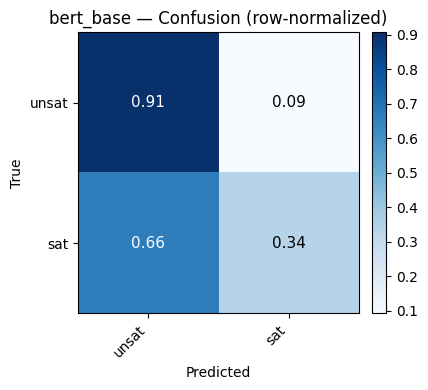

In [2]:
# ▶️ Run ONE model at a time on the syllogistic dataset
# Pick ONE: "bert", "roberta", "gpt4", or "local_lm" (no API key needed)
MODEL_TO_RUN = "bert"   # ← change this

# ================= Setup & upload =================
# from google.colab import files
# uploaded = files.upload()  # choose your syllogistic CSV (must have 'sentences' and 'sat' or 'label')

CSV_NAME         = "syllogistic.csv"
TEXT_MAX_LEN     = 256
NUM_EPOCHS       = 3
LR               = 2e-5
TRAIN_BS         = 16
EVAL_BS          = 32
WARMUP_RATIO     = 0.06
WEIGHT_DECAY     = 0.01
RANDOM_STATE     = 42
CLASS_NAMES      = ["unsat","sat"]

# For GPT-4 zero-shot:
OPENAI_MODEL     = "gpt-4o"
EVAL_LIMIT_API   = None   # set e.g. 200 to limit GPT-4 eval size

# ================= Imports & helpers =================
import os, json, ast, re, shutil
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, f1_score

OUTDIR = Path("one_model_run"); OUTDIR.mkdir(exist_ok=True, parents=True)

SEP_TOKEN = "[SEP]"

def normalize_label(v):
    if isinstance(v,str):
        s=v.strip().lower()
        if s in {"sat","satisfiable","1","true"}: return 1
        if s in {"unsat","unsatisfiable","0","false"}: return 0
    if isinstance(v,(int,np.integer)) and v in (0,1): return int(v)
    raise ValueError(f"Bad label: {v}")

def parse_sent(cell, sep=SEP_TOKEN):
    if isinstance(cell, list): return f" {sep} ".join(cell)
    if isinstance(cell, str):
        s = cell.strip()
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list) and all(isinstance(x,str) for x in parsed):
                    return f" {sep} ".join(parsed)
            except Exception:
                pass
        return s
    return str(cell)

def plot_cm(cm, class_names, title, normalize=False, save_path=None):
    cm_plot = cm.astype(float)
    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        row_sums[row_sums==0]=1.0
        cm_plot = cm_plot / row_sums
    plt.figure(figsize=(4.5,4))
    im = plt.imshow(cm_plot, interpolation='nearest', cmap='Blues', aspect='equal')
    plt.title(title); plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks=np.arange(len(class_names))
    plt.xticks(ticks,class_names,rotation=45,ha='right'); plt.yticks(ticks,class_names)
    thr = cm_plot.max()/2 if cm_plot.max()>0 else 0.5
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = f"{cm_plot[i,j]:.2f}" if normalize else f"{int(cm_plot[i,j])}"
            plt.text(j,i,val,ha="center",va="center",color="white" if cm_plot[i,j]>thr else "black",fontsize=11)
    plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

# ================= Load data =================
df = pd.read_csv(CSV_NAME)
label_col = "label" if "label" in df.columns else "sat" if "sat" in df.columns else None
assert label_col is not None, "Expected 'label' or 'sat' column."
assert "sentences" in df.columns, "Expected 'sentences' column."

df["y"]    = df[label_col].apply(normalize_label).astype(int)
df["text"] = df["sentences"].apply(parse_sent)

X_train, X_val, y_train, y_val = train_test_split(
    df["text"].tolist(), df["y"].to_numpy(),
    test_size=0.2, stratify=df["y"].to_numpy(), random_state=RANDOM_STATE
)

print(f"Train={len(X_train)} | Val={len(X_val)} | Val sat rate={np.mean(y_val):.3f}")

# ================= Branch per model =================
if MODEL_TO_RUN in {"bert","roberta"}:
    # Try to import 🤗; if missing, install minimal deps
    try:
        import torch
        from datasets import Dataset
        from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                                  DataCollatorWithPadding, TrainingArguments, Trainer, set_seed)
    except Exception:
        !pip -q install "transformers>=4.30.0" "datasets>=2.14.0" "accelerate>=0.21.0" evaluate
        import torch
        from datasets import Dataset
        from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                                  DataCollatorWithPadding, TrainingArguments, Trainer, set_seed)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8

    model_name = "bert-base-uncased" if MODEL_TO_RUN=="bert" else "roberta-base"
    outname    = f"{MODEL_TO_RUN}_base"

    # Build datasets and KEEP labels
    train_ds = Dataset.from_dict({"text": X_train, "label": y_train}).rename_column("label","labels")
    val_ds   = Dataset.from_dict({"text": X_val,   "label": y_val}).rename_column("label","labels")

    set_seed(RANDOM_STATE)

    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    def tok_fn(batch): return tok(batch["text"], truncation=True, max_length=TEXT_MAX_LEN)

    # Remove ONLY 'text' so 'labels' stays
    enc_train = train_ds.map(tok_fn, batched=True, remove_columns=["text"])
    enc_val   = val_ds.map(tok_fn,   batched=True, remove_columns=["text"])

    collator  = DataCollatorWithPadding(tokenizer=tok)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2, problem_type="single_label_classification"
    ).to(device)

    # ---- Compatibility shim for TrainingArguments (handles old/new versions) ----
    import inspect
    def make_training_args(out_dir, bf16=False):
        from transformers import TrainingArguments
        want = dict(
            output_dir=str(out_dir),
            learning_rate=LR,
            per_device_train_batch_size=TRAIN_BS,
            per_device_eval_batch_size=EVAL_BS,
            num_train_epochs=NUM_EPOCHS,
            weight_decay=WEIGHT_DECAY,
            warmup_ratio=WARMUP_RATIO,
            logging_steps=50,
            seed=RANDOM_STATE,
            report_to=[],
            evaluation_strategy="epoch",  # old name (may not exist)
            eval_strategy="epoch",        # new name (≥4.46)
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            fp16=(torch.cuda.is_available() and not bf16),
            bf16=bf16
        )
        params = set(inspect.signature(TrainingArguments.__init__).parameters.keys())
        safe = {k: v for k, v in want.items() if k in params}
        return TrainingArguments(**safe)

    args = make_training_args(OUTDIR / outname, bf16=bf16)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(-1)
        acc = accuracy_score(labels, preds)
        p, r, f1m, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
        return {"accuracy": acc, "f1_macro": f1m, "precision_macro": p, "recall_macro": r}

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=enc_train,
        eval_dataset=enc_val,
        tokenizer=tok,
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    trainer.train()

    # Evaluate
    preds = trainer.predict(enc_val)
    y_pred = preds.predictions.argmax(-1)

    print(f"\nValidation report — {outname}:")
    print(classification_report(y_val, y_pred, digits=4, target_names=CLASS_NAMES))
    cm = confusion_matrix(y_val, y_pred, labels=[0,1])
    plot_cm(cm, CLASS_NAMES, f"{outname} — Confusion (counts)", normalize=False, save_path=OUTDIR/f"cm_{outname}_counts.png")
    plot_cm(cm, CLASS_NAMES, f"{outname} — Confusion (row-normalized)", normalize=True, save_path=OUTDIR/f"cm_{outname}_normalized.png")

elif MODEL_TO_RUN == "gpt4":
    # Zero-shot via OpenAI API
    def normalize_api_label(txt: str):
        t = (txt or "").strip().lower()
        t0 = re.split(r'[\s\.\,\n]', t)[0]
        if "unsat" in t0 or t0 == "0": return 0
        if "sat"   in t0 or t0 == "1": return 1
        if "unsat" in t: return 0
        if "sat"   in t: return 1
        return None

    def gpt4_call(prompt: str):
        key = os.getenv("OPENAI_API_KEY")
        if not key:
            return "sat"  # safe default if no key set
        try:
            !pip -q install --upgrade openai
            from openai import OpenAI
            client = OpenAI(api_key=key)
            resp = client.chat.completions.create(
                model=OPENAI_MODEL,
                messages=[
                    {"role":"system","content":"You are a concise, deterministic binary classifier."},
                    {"role":"user","content":prompt}
                ],
                temperature=0,
            )
            return resp.choices[0].message.content.strip()
        except Exception as e:
            print("OpenAI error:", e); return None

    texts = X_val if EVAL_LIMIT_API is None else X_val[:EVAL_LIMIT_API]
    ys    = y_val if EVAL_LIMIT_API is None else y_val[:EVAL_LIMIT_API]
    preds = []
    for i, s in enumerate(texts):
        prompt = ("You are a formal-logic classifier. Decide if the fragment is SATISFIABLE (sat) or "
                  "UNSATISFIABLE (unsat). Return exactly one word: 'sat' or 'unsat'.\n\nFragment:\n" + s)
        out = gpt4_call(prompt)
        lab = normalize_api_label(out or "")
        preds.append(1 if lab is None else lab)
        if (i+1)%20==0: print(f"  processed {i+1}/{len(texts)}")

    print("\nValidation report — gpt4_zeroshot:")
    print(classification_report(ys, preds, digits=4, target_names=CLASS_NAMES))
    cm = confusion_matrix(ys, preds, labels=[0,1])
    plot_cm(cm, CLASS_NAMES, "gpt4_zeroshot — Confusion (counts)", normalize=False, save_path=OUTDIR/"cm_gpt4_counts.png")
    plot_cm(cm, CLASS_NAMES, "gpt4_zeroshot — Confusion (row-normalized)", normalize=True, save_path=OUTDIR/"cm_gpt4_normalized.png")

elif MODEL_TO_RUN == "local_lm":
    # Tiny local LLM baseline (no API key)
    try:
        import torch
        from transformers import AutoTokenizer, AutoModelForCausalLM
    except Exception:
        !pip -q install -U "transformers>=4.44.2" "accelerate>=0.33.0" sentencepiece
        import torch
        from transformers import AutoTokenizer, AutoModelForCausalLM

    LM_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tok = AutoTokenizer.from_pretrained(LM_NAME, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(
        LM_NAME,
        torch_dtype=torch.float16 if device=="cuda" else torch.float32,
        device_map="auto" if device=="cuda" else None
    ).to(device)

    def normalize_local_label(txt: str):
        t = (txt or "").strip().lower()
        t0 = re.split(r'[\s\.\,\n]', t)[0]
        if "unsat" in t0 or t0 == "0": return 0
        if "sat"   in t0 or t0 == "1": return 1
        if "unsat" in t: return 0
        if "sat"   in t: return 1
        return None

    preds=[]
    for i, s in enumerate(X_val):
        prompt = ("You are a formal-logic classifier. Decide if the fragment is SATISFIABLE (sat) or "
                  "UNSATISFIABLE (unsat). Return exactly one word: 'sat' or 'unsat'.\n\nFragment:\n" + s)
        inp = tok(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            out = model.generate(**inp, max_new_tokens=4, do_sample=False, temperature=0.0, pad_token_id=tok.eos_token_id)
        gen = tok.decode(out[0][inp["input_ids"].shape[1]:], skip_special_tokens=True)
        lab = normalize_local_label(gen)
        preds.append(1 if lab is None else lab)
        if (i+1)%20==0: print(f"  processed {i+1}/{len(X_val)}")

    print("\nValidation report — local_lm:")
    print(classification_report(y_val, preds, digits=4, target_names=CLASS_NAMES))
    cm = confusion_matrix(y_val, preds, labels=[0,1])
    plot_cm(cm, CLASS_NAMES, "local_lm — Confusion (counts)", normalize=False, save_path=OUTDIR/"cm_local_counts.png")
    plot_cm(cm, CLASS_NAMES, "local_lm — Confusion (row-normalized)", normalize=True, save_path=OUTDIR/"cm_local_normalized.png")

else:
    raise ValueError("MODEL_TO_RUN must be one of: 'bert', 'roberta', 'gpt4', 'local_lm'")
